## TA Review 7
Tobias

### 0. Midterm Tips

- Have a template notebook for the exam. This will let you hit the ground running and not waste time setting up imports, etc.
- Skip questions! The questions are not in order of difficulty (example: 3.5/3.6 of the last midterm were much easier than 3.4, and a lot of student didn't do them).
- We aren't trying to trick you, so if something isn't clear state your assumptions and move on. We typically prepare multiple versions of the solutions, to account for different interpretations of the questions.
- Please don't use Jupyter in browser. VSCode or PyCharm are much better options that let you debug, get imports, autocomplete, etc.

### 1. Diversification (Barnstable)

Remember that $\sigma \propto \sqrt{t}$, but $\mu \propto t$. This means that the expected return grows linearly with time, but the standard deviation grows with the square root of time. This means that the expected return grows faster than the standard deviation, so the Sharpe ratio increases with time.

That is, if you have a positive expected return, then the longer you hold the asset, the better the Sharpe will be. However, this doesn't mean that holding the asset is *less* risky. It is actually MORE risky because your variance is also increasing with time.

### 2. Factors

Mathematical intuition. Factor models (not just in finance), are a way to model one variable as a linear combination of other variables. In particular:

$$
X = L \cdot F + \epsilon
$$

Where $X \in \mathbb{R}^{p \times n}$, $L \in \mathbb{R}^{p \times k}$, $F \in \mathbb{R}^{k \times n}$, and $\epsilon \in \mathbb{R}^{p \times n}$. Specifically, this is saying that $X$ is made up of some low-dimensional factors $F$ and some noise $\epsilon$ ($k << p$).

In finance, we can think of $X$ as our universe of assets, and $F$ as the factors that drive the returns of those assets. A core idea of factor models is that *we cannot obverse the factors directly*, and that these factors are orthogonal. So, we need to estimate the factors from the returns of the assets.

Some thoughts:
1. Does this make sense in the context of the CAPM? What did we think about $\epsilon$ in the CAPM?
2. What would be a natural way to get the loadings matrix?

Review of the factors:

- MKT: Market factor
- SMB: "Small minus big" factor, the idea is that small-cap stocks outperform large-cap stocks
- HML: "High minus low" factor, the idea is that value stocks outperform growth stocks (stocks with high book-to-market ratios outperform stocks with low book-to-market ratios)

Note that HML is actually a blend of SMB and and book-to-market. Why? The idea is to make the factor have 0 correlation to the other factors.

HML = 0.5 * (Small Value + Big Value) - 0.5 * (Small Growth + Big Growth), where Small/Big are from SMB.

- RMW (Robust Minus Weak): Robust operating profitability minus weak operating profitability. Again we weight the small and big stocks.

RMW = 0.5 * (Small Robust + Big Robust) - 0.5 * (Small Weak + Big Weak)

- CMA (Conservative Minus Aggressive): Conservative investment minus aggressive investment. 

CMA = 0.5 * (Small Conservative + Big Conservative) - 0.5 * (Small Aggressive + Big Aggressive)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import seaborn as sns

plt.style.use('seaborn')

factors = pd.read_excel(
    '../data/factor_pricing_data.xlsx', sheet_name='factors (excess returns)', index_col=0, parse_dates=[0]
)
portfolios = pd.read_excel(
    '../data/factor_pricing_data.xlsx', sheet_name='portfolios (excess returns)', index_col=0, parse_dates=[0]
)

Do the factors succeed in being uncorrelated?

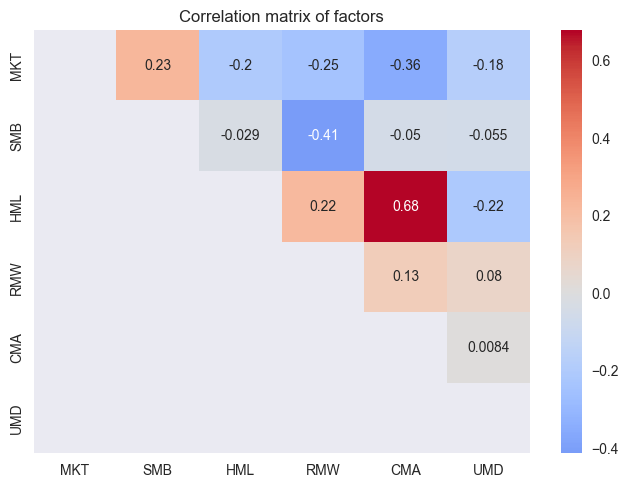

In [2]:
# Make upper triangle of correlation matrix NaN
factors_corr = factors.corr()
mask = np.triu(np.ones(factors_corr.shape), k=1).astype(bool)
factors_corr = factors_corr.where(mask)

plt.figure()
sns.heatmap(factors_corr, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation matrix of factors')
plt.show()

What sticks out? CMA and HML. 

This is why AQR does use CMA factor -- since it really does not add much to the model.

Bonus content: Can we do a PCA?

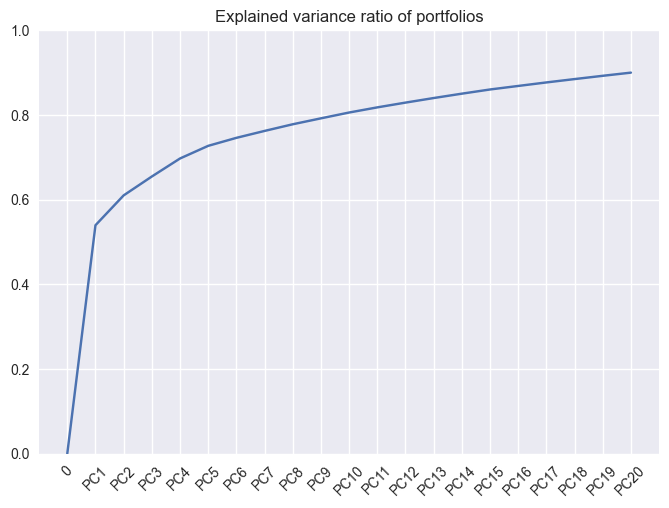

In [3]:
# Do PCA on portfolios 
pca = PCA()
pca.fit(portfolios)
portfolios_pca = pca.transform(portfolios)

# Plot explained variance ratio
plt.figure()
plt.plot([0] + list(np.cumsum(pca.explained_variance_ratio_[:20])))
plt.xticks(np.arange(0, 20, 1))
plt.xticks(rotation=45)
plt.xticks(ticks=np.arange(0, 21, 1), labels=["0"] + [f'PC{i+1}' for i in range(20)])
plt.ylim(0, 1)
plt.title('Explained variance ratio of portfolios')
plt.show()

So it does seem that relatively few PCs can explain most of the variance in the data.

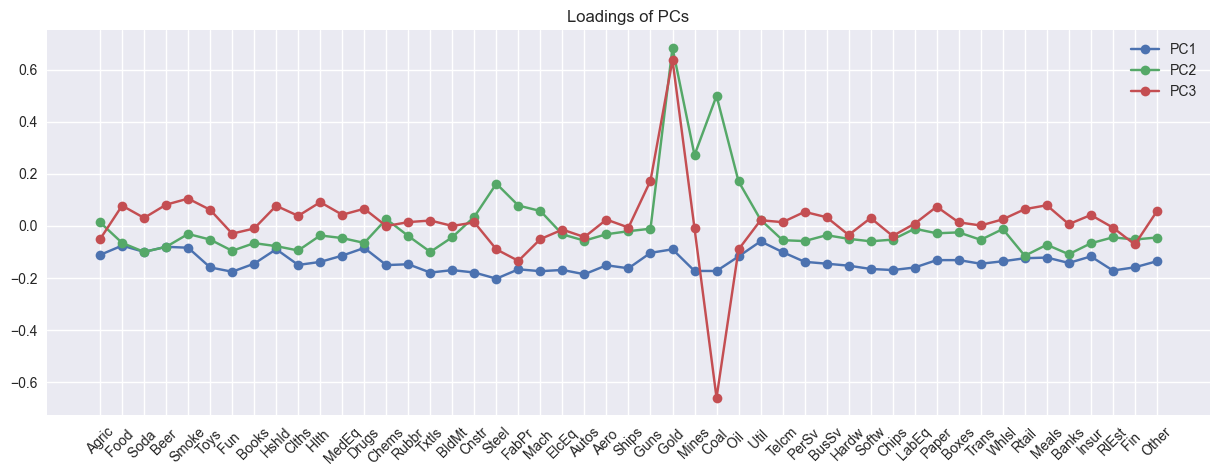

In [4]:
# Plot the loadings of the first two principal components
plt.figure(figsize=(15, 5))
plt.plot(pca.components_[0], label='PC1', marker='o')
plt.plot(pca.components_[1], label='PC2', marker='o')
plt.plot(pca.components_[2], label='PC3', marker='o')
plt.xticks(np.arange(len(portfolios.columns)), portfolios.columns, rotation=45);
plt.legend()
plt.title('Loadings of PCs')
plt.show()

So, PC1 is pretty clear -- it's the market factor. As for the others...?

### 3. Anyway, back to momentum

In [5]:
raw_data = pd.read_excel('../data/momentum_data.xlsx', sheet_name=None)
sheets = list(raw_data.keys())

ff_factors = raw_data[sheets[1]].set_index('Date')
momentum = raw_data[sheets[2]].set_index('Date')
ff_factors['UMD'] = momentum['UMD']

mom_deciles = raw_data[sheets[3]].set_index('Date')
tercile_port = raw_data[sheets[4]].set_index('Date')
rf = raw_data[sheets[5]].set_index('Date')

Fama-French momentum:

FF-UMD = 0.5 * (Small Up + Big Up) - 0.5 * (Small Down + Big Down)

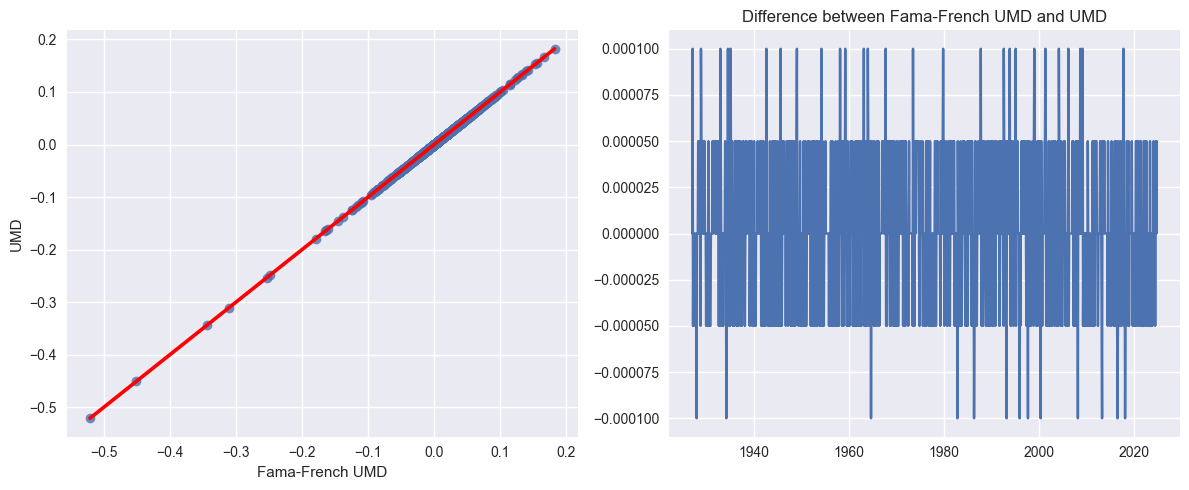

In [6]:
ff_umd = 0.5 * (tercile_port['BIG HiPRIOR'] + tercile_port['SMALL HiPRIOR']) - 0.5 * (tercile_port['BIG LoPRIOR'] + tercile_port['SMALL LoPRIOR'])

fig, ax = plt.subplots(1, 2, figsize=(12, 5))

sns.regplot(x=ff_umd, y=ff_factors['UMD'], ax=ax[0], line_kws={'color': 'red'})
ax[0].set_xlabel('Fama-French UMD')
ax[1].plot(ff_factors['UMD'] - ff_umd)
ax[1].set_title('Difference between Fama-French UMD and UMD')
fig.tight_layout()
plt.show()

What about long-only momentum?

<AxesSubplot:xlabel='Long Only UMD', ylabel='UMD'>

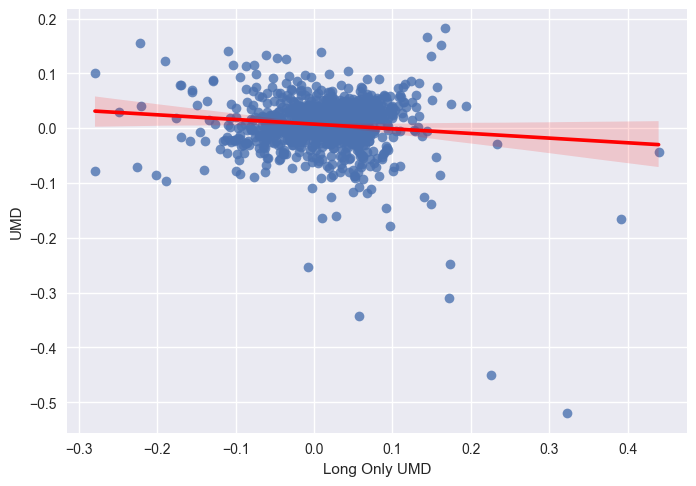

In [7]:
mom_long = 0.5 * (tercile_port['BIG HiPRIOR'] + tercile_port['SMALL HiPRIOR'])

sns.regplot(x=mom_long.to_frame("Long Only UMD"), y=ff_factors['UMD'], line_kws={'color': 'red'})

Doesn't really look like momentum does it?

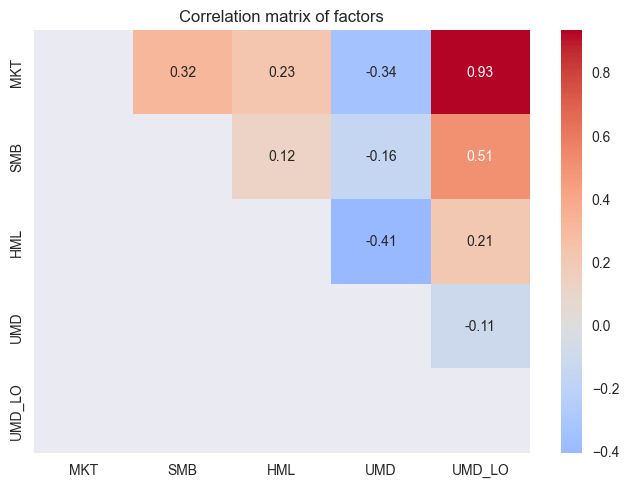

In [8]:
# Make upper triangle of correlation matrix NaN
ff_factors['UMD_LO'] = mom_long

factors_corr = ff_factors.corr()
mask = np.triu(np.ones(factors_corr.shape), k=1).astype(bool)
factors_corr = factors_corr.where(mask)

plt.figure()
sns.heatmap(factors_corr, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation matrix of factors')
plt.show()